---
title: "My Predictive Model Report"
author: "Your Name"
date: "today"
format: 
  html:
    toc: true
    toc-location: left
    code-fold: true
    theme: cosmo
execute: 
  echo: false
  warning: false
  freeze: true
---

In [1]:
#Libraries used in the project
#Basic libraries
import numpy as np
import pandas as pd
from datetime import datetime
from io import StringIO #yes
#Data visualization libraries
from lets_plot import *
LetsPlot.setup_html()
import arviz as az
import great_tables as gt
#Web scraping libraries
import selenium as se
from curl_cffi import requests
from bs4 import BeautifulSoup
import time
#For database connection and manipulation 
import duckdb
#For Hierarchical modeling
import pymc as pm
import xarray as xr
#for pyshiny
import shiny
import requests as req
import vetiver
import pins
import logging 
import json
import plotly.express as px


In [3]:
#Getting Unique clubs in 2023/24 and 2024/25 seasons #unit test check for unique number of ids should be 23
season_23_24 = pd.read_csv('2023-24.csv')
season_24_25 = pd.read_csv('2024-25.csv')
frames = [season_23_24, season_24_25, ]
full = pd.concat(frames)
full.rename(columns={'FTHG': 'Home_Goals'}, inplace=True)
full.rename(columns={'FTAG': 'Away_Goals'}, inplace=True)
full.rename(columns={'FTR': 'Result'}, inplace=True)
team_ids = pd.read_csv('team_ids.csv') # manually entered in excel taken from footballcritc's website as team ids are unique beyond seasons
team_ids

,Season,team_id,slug
0,season-2023-2024,459,Wolverhampton Wanderers FC
1,season-2024-2025,459,Wolverhampton Wanderers FC
2,season-2023-2024,460,Fulham FC
3,season-2024-2025,460,Fulham FC
4,season-2023-2024,461,Aston Villa FC
5,season-2024-2025,461,Aston Villa FC
6,season-2023-2024,462,Liverpool FC
7,season-2024-2025,462,Liverpool FC
8,season-2023-2024,464,Manchester City FC
9,season-2024-2025,464,Manchester City FC


In [4]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7",
    "Accept-Language": "en-US,en;q=0.9",
    "Accept-Encoding": "gzip, deflate, br",
}
team_ids
season_id_map = {
    'season-2023-2024': 68731,
    'season-2024-2025': 72764
}
def team_match_ids(url):
    try:
        response = requests.get(url, headers=headers, impersonate="chrome110", timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')
        
        table = soup.find('table', class_='stats-table teamMatches player')
        if not table:
            return []

        match_data = []
        rows = table.find_all('tr', class_='row')
        
        for row in rows:
            date_cell = row.find('td', class_='date')
            date_text = date_cell.get_text(strip=True) if date_cell else None            
            comp_cell = row.find('td', class_='comp') 
            competition_name = comp_cell.get_text(strip=True) if comp_cell else None
            match_link = row.find('a', href=lambda x: x and '/match-stats/' in x)
            if match_link:
                match_href = match_link['href']
                match_id = match_href.split('/')[-1]
                match_data.append({
                    'match_id': match_id,
                    'date': date_text,
                    'competition': competition_name
                })

        return match_data

    except Exception as e:
        print(f"Error processing {url}: {e}")
        return []

all_matches = []

for _, row in team_ids.iterrows():
    team_name = row['slug']
    team_id = row['team_id']
    season_slug = row['Season']
    season_id = season_id_map.get(season_slug)

    if not season_id:
        print(f"Warning: Skipping {team_name} for season {season_slug} - No Season ID found.")
        continue

    url = f"https://www.footballcritic.com/{team_name}/team-matches/{team_id}/{season_slug}/{season_id}"
    matches = team_match_ids(url)

    for match in matches:
        all_matches.append({
            'team_name': team_name,
            'team_id': team_id,
            'season': season_slug,
            'season_id': season_id,
            'match_id': match['match_id'],
            'date': match['date'],
            'competition': match['competition']
        })

    print(f"Processed {team_name} in {season_slug}")
    time.sleep(2)

df_matches = pd.DataFrame(all_matches)
df_matches.to_csv('team_match_ids_with_dates_and_comps.csv', index=False)


Processed Wolverhampton Wanderers FC in season-2023-2024
Processed Wolverhampton Wanderers FC in season-2024-2025
Processed Fulham FC in season-2023-2024
Processed Fulham FC in season-2024-2025
Processed Aston Villa FC in season-2023-2024
Processed Aston Villa FC in season-2024-2025
Processed Liverpool FC in season-2023-2024
Processed Liverpool FC in season-2024-2025
Processed Manchester City FC in season-2023-2024
Processed Manchester City FC in season-2024-2025
Processed Newcastle United FC in season-2023-2024
Processed Newcastle United FC in season-2024-2025
Processed Arsenal FC in season-2023-2024
Processed Arsenal FC in season-2024-2025
Processed Chelsea FC in season-2023-2024
Processed Chelsea FC in season-2024-2025
Processed Tottenham Hotspur FC in season-2023-2024
Processed Tottenham Hotspur FC in season-2024-2025
Processed Everton FC in season-2023-2024
Processed Everton FC in season-2024-2025
Processed Manchester United FC in season-2023-2024
Processed Manchester United FC in

In [6]:
Match_info = pd.read_csv('team_match_ids_with_dates_and_comps.csv')
Match_info.drop(Match_info[Match_info['competition'] != 'EPL'].index, inplace = True)
Match_info['date'] = pd.to_datetime(Match_info['date'], format='%b %d, %Y')
Match_info
myelo = full.copy()
myelo = myelo[['Date', 'HomeTeam', 'AwayTeam', 'Home_Goals', 'Away_Goals']]
myelo['Date'] = pd.to_datetime(myelo['Date'], format= '%d/%m/%Y')
name_mapping = {
    "Man United": "Manchester United FC",
    "Wolves": "Wolverhampton Wanderers FC",
    "Everton": "Everton FC",
    "Chelsea": "Chelsea FC",
    "Man City": "Manchester City FC",
    "Norwich": "Norwich City FC",
    "Sheffield United": "Sheffield United FC",
    "Brighton": "Brighton & Hove Albion FC",
    "Aston Villa": "Aston Villa FC",
    "Leeds": "Leeds United FC",
    "Fulham": "Fulham FC",
    "Brentford": "Brentford FC",
    "Southampton": "Southampton FC",
    "Burnley": "Burnley FC",
    "Newcastle": "Newcastle United FC",
    "Arsenal": "Arsenal FC",
    "West Ham": "West Ham United FC",
    "Nott'm Forest": "Nottingham Forest FC",
    "Luton": "Luton Town FC",
    "Ipswich": "Ipswich Town FC",
    "Tottenham": "Tottenham Hotspur FC",
    "Leicester": "Leicester City FC",
    "Bournemouth": "AFC Bournemouth",
    "Liverpool": "Liverpool FC",
    "Crystal Palace": "Crystal Palace FC"
}
myelo = myelo.replace(name_mapping)
myelo

,Date,HomeTeam,AwayTeam,Home_Goals,Away_Goals
0,2023-08-11,Burnley FC,Manchester City FC,0,3
1,2023-08-12,Arsenal FC,Nottingham Forest FC,2,1
2,2023-08-12,AFC Bournemouth,West Ham United FC,1,1
3,2023-08-12,Brighton & Hove Albion FC,Luton Town FC,4,1
4,2023-08-12,Everton FC,Fulham FC,0,1
...,...,...,...,...,...
375,2025-05-25,Newcastle United FC,Everton FC,0,1
376,2025-05-25,Nottingham Forest FC,Chelsea FC,0,1
377,2025-05-25,Southampton FC,Arsenal FC,1,2
378,2025-05-25,Tottenham Hotspur FC,Brighton & Hove Albion FC,1,4


In [7]:
conn = duckdb.connect()
conn.register('ids', Match_info) #football critic data
conn.register('myelo', myelo) # from football-uk.co
query = """
SELECT 
    a.season_id, a.match_id,
    b.*
FROM ids a
INNER JOIN myelo b
ON a.date = b.Date
AND (a.team_name = b.HomeTeam OR a.team_name = b.AwayTeam)
ORDER BY b.Date
"""
result = conn.execute(query).df()
result.to_csv('Elo_Table_Pre.csv', index=False)  # Changed from df to result
conn.close()
result = result.drop_duplicates()
result = result.replace('Brighton & Hove Albion FC', 'Brighton Hove Albion FC')
result
# team_ids = p

,season_id,match_id,Date,HomeTeam,AwayTeam,Home_Goals,Away_Goals
0,68731,3009108,2023-08-11,Burnley FC,Manchester City FC,0,3
2,68731,3009114,2023-08-12,Newcastle United FC,Aston Villa FC,5,1
4,68731,3009113,2023-08-12,Sheffield United FC,Crystal Palace FC,0,1
6,68731,3009112,2023-08-12,Everton FC,Fulham FC,0,1
8,68731,3009111,2023-08-12,Brighton Hove Albion FC,Luton Town FC,4,1
...,...,...,...,...,...,...,...
1510,72764,3356971,2025-05-25,Manchester United FC,Aston Villa FC,2,0
1512,72764,3356970,2025-05-25,Liverpool FC,Crystal Palace FC,1,1
1514,72764,3356969,2025-05-25,Ipswich Town FC,West Ham United FC,1,3
1516,72764,3356968,2025-05-25,Fulham FC,Manchester City FC,0,2


In [8]:
#Elo Creater
team_id_map = Match_info.copy()
team_id_map = team_id_map.loc[(team_id_map['season'] == 'season-2024-2025') | (team_id_map['season'] == 'season-2023-2024')]#to account for promoted teams
team_id_map['team_name'] = team_id_map['team_name'].replace('Brighton & Hove Albion FC', 'Brighton Hove Albion FC')
team_id_map = team_id_map.set_index('team_name')['team_id'].to_dict()
result['home_team_id'] = result['HomeTeam'].map(team_id_map)
result['away_team_id'] = result['AwayTeam'].map(team_id_map)
result


,season_id,match_id,Date,HomeTeam,AwayTeam,Home_Goals,Away_Goals,home_team_id,away_team_id
0,68731,3009108,2023-08-11,Burnley FC,Manchester City FC,0,3,492,464
2,68731,3009114,2023-08-12,Newcastle United FC,Aston Villa FC,5,1,466,461
4,68731,3009113,2023-08-12,Sheffield United FC,Crystal Palace FC,0,1,480,508
6,68731,3009112,2023-08-12,Everton FC,Fulham FC,0,1,473,460
8,68731,3009111,2023-08-12,Brighton Hove Albion FC,Luton Town FC,4,1,510,502
...,...,...,...,...,...,...,...,...,...
1510,72764,3356971,2025-05-25,Manchester United FC,Aston Villa FC,2,0,475,461
1512,72764,3356970,2025-05-25,Liverpool FC,Crystal Palace FC,1,1,462,508
1514,72764,3356969,2025-05-25,Ipswich Town FC,West Ham United FC,1,3,503,496
1516,72764,3356968,2025-05-25,Fulham FC,Manchester City FC,0,2,460,464


In [9]:
matches = result[['season_id','match_id', 'Date', 'home_team_id', 'away_team_id', 'Home_Goals', 'Away_Goals']]
matches

,season_id,match_id,Date,home_team_id,away_team_id,Home_Goals,Away_Goals
0,68731,3009108,2023-08-11,492,464,0,3
2,68731,3009114,2023-08-12,466,461,5,1
4,68731,3009113,2023-08-12,480,508,0,1
6,68731,3009112,2023-08-12,473,460,0,1
8,68731,3009111,2023-08-12,510,502,4,1
...,...,...,...,...,...,...,...
1510,72764,3356971,2025-05-25,475,461,2,0
1512,72764,3356970,2025-05-25,462,508,1,1
1514,72764,3356969,2025-05-25,503,496,1,3
1516,72764,3356968,2025-05-25,460,464,0,2


In [10]:
# starting_elo#
starting_elo = {"Manchester United FC":1877.080444,
    "Wolverhampton Wanderers FC":1715.651001,
    "Everton FC":1699.523682,
    "Chelsea FC":1788.11755371,
    "Manchester City FC": 2080.86743164,
    "Sheffield United FC":1644.08129883,
    "Brighton Hove Albion FC":1832.391968,
    "Aston Villa FC":1816.943237,
    "Fulham FC": 1745.379028,
    "Brentford FC":1824.3449707,
    "Southampton FC":1599.60339355,
    "Burnley FC":1726.4185791,
    "Newcastle United FC":1887.082153,
    "Arsenal FC":1921.475342,
    "West Ham United FC": 1777.576782,
    "Nottingham Forest FC": 1671.890747,
    "Luton Town FC":1602.344727,
    "Ipswich Town FC":1568.32556152,
    "Tottenham Hotspur FC":1815.88818359,
    "Leicester City FC":1643.66943359,
    "AFC Bournemouth":1660.65661621,
    "Liverpool FC":1943.996216,
    "Crystal Palace FC":1757.40673828}
team_id_map
id_to_name = {tid: name for name, tid in team_id_map.items()}
base_elo = {tid: starting_elo[name] for tid, name in id_to_name.items()}
base_elo


{459: 1715.651001,
 460: 1745.379028,
 461: 1816.943237,
 462: 1943.996216,
 464: 2080.86743164,
 466: 1887.082153,
 467: 1921.475342,
 471: 1788.11755371,
 472: 1815.88818359,
 473: 1699.523682,
 475: 1877.080444,
 480: 1644.08129883,
 481: 1671.890747,
 489: 1643.66943359,
 492: 1726.4185791,
 496: 1777.576782,
 500: 1824.3449707,
 502: 1602.344727,
 503: 1568.32556152,
 506: 1599.60339355,
 508: 1757.40673828,
 510: 1832.391968,
 2169: 1660.65661621}

In [11]:
starting_elo # unit test to check if there's 760 and also if delta elo is appropriate
team_id_map

id_to_name = {tid: name for name, tid in team_id_map.items()}
id_to_elo = {tid: starting_elo[name] for tid, name in id_to_name.items()}

K = 30
home_adv_pts = 100  
import pandas as pd

def goal_diff_factor(goal_diff):
    if goal_diff <= 1:
        return 1.0
    elif goal_diff == 2:
        return 1.5
    else:
        return (11 + goal_diff) / 8.0

def expected_prob(r_a, r_b, home_adv_pts=100.0):
    return 1.0 / (1.0 + 10 ** ((r_b - (r_a + home_adv_pts)) / 400.0))

def update_elo(matches_df, id_to_elo, K=30, home_adv_pts=100.0):
    elo_history = []

    for _, row in matches_df.sort_values("Date").iterrows():
        season_id = row["season_id"]
        match_id = row["match_id"]
        home_id = row["home_team_id"]
        away_id = row["away_team_id"]
        home_goals = row["Home_Goals"]
        away_goals = row["Away_Goals"]

        # Get current ratings
        r_home = id_to_elo[home_id]
        r_away = id_to_elo[away_id]

        # Match result (W)
        if home_goals > away_goals:
            w_home, w_away = 1.0, 0.0
        elif home_goals < away_goals:
            w_home, w_away = 0.0, 1.0
        else:
            w_home, w_away = 0.5, 0.5

        # Expected result (We)
        we_home = expected_prob(r_home, r_away, home_adv_pts)
        we_away = 1 - we_home

        # Goal difference factor (G)
        g = goal_diff_factor(abs(home_goals - away_goals))

        # New ratings
        new_r_home = r_home + K * g * (w_home - we_home)
        new_r_away = r_away + K * g * (w_away - we_away)

        delta_home = K * g * (w_home - we_home)
        delta_away = K * g * (w_away - we_away) 
        # Store history with match_id
        elo_history.append({
            "season_id":season_id,
            "match_id": match_id,
            "date": row["Date"],
            "home_team_id": home_id,
            "away_team_id": away_id,
            "old_home_elo": r_home,
            "old_away_elo": r_away,
            "new_home_elo": new_r_home,
            "new_away_elo": new_r_away,
            "delta_home": delta_home,
            "delta_away": delta_away
        })

        # Update ratings for next match
        id_to_elo[home_id] = new_r_home
        id_to_elo[away_id] = new_r_away

    return pd.DataFrame(elo_history)

finale = update_elo(matches,id_to_elo, K=30, home_adv_pts=100.0)
finale

,season_id,match_id,date,home_team_id,away_team_id,old_home_elo,old_away_elo,new_home_elo,new_away_elo,delta_home,delta_away
0,68731,3009108,2023-08-11,492,464,1726.418579,2080.867432,1716.561932,2090.724079,-9.856647,9.856647
1,68731,3009114,2023-08-12,466,461,1887.082153,1816.943237,1902.439032,1801.586358,15.356879,-15.356879
2,68731,3009113,2023-08-12,480,508,1644.081299,1757.406738,1629.656322,1771.831715,-14.424976,14.424976
3,68731,3009112,2023-08-12,473,460,1699.523682,1745.379028,1682.204811,1762.697899,-17.318871,17.318871
4,68731,3009111,2023-08-12,510,502,1832.391968,1602.344727,1839.223230,1595.513465,6.831262,-6.831262
...,...,...,...,...,...,...,...,...,...,...,...
755,72764,3356974,2025-05-25,506,467,1469.970821,2007.399168,1467.732727,2009.637262,-2.238094,2.238094
756,72764,3356975,2025-05-25,472,510,1715.111544,1835.024214,1690.364372,1859.771386,-24.747172,24.747172
757,72764,3356976,2025-05-25,459,500,1728.284043,1824.947939,1728.140016,1825.091966,-0.144027,0.144027
758,72764,3356973,2025-05-25,481,471,1840.795745,1896.664964,1823.900647,1913.560063,-16.895098,16.895098


In [ ]:
#This will take at least 1 hour to run
# from selenium import webdriver#CHAT
# from selenium.webdriver.chrome.service import Service
# from selenium.webdriver.common.by import By
# from selenium.webdriver.chrome.options import Options
# from selenium.webdriver.support.ui import WebDriverWait
# from selenium.webdriver.support import expected_conditions as EC


# def create_match_url(row):
#     home_team_slug = row['HomeTeam'].replace(' ', '-').lower()
#     away_team_slug = row['AwayTeam'].replace(' ', '-').lower()
#     match_id = row['match_id']
    
#     url = f"https://www.footballcritic.com/premier-league-{home_team_slug}-{away_team_slug}/match-report/{match_id}"
#     return url
# prematching = pd.read_csv('Elo_Table_Pre.csv')
# prematching = prematching.drop_duplicates()
# # prematching = prematching.replace('Brighton & Hove Albion FC', 'Brighton Hove Albion FC')
# prematching['URL'] = prematching.apply(create_match_url, axis=1)
# prematching


# def extract_player_info(player, team_id, match_id):
#     try:
#         name = player.find_element(By.CSS_SELECTOR, "span.name a").text.strip()
#         rating_elem = player.find_elements(By.CSS_SELECTOR, "div.rating")
#         rating = rating_elem[0].text.strip() if rating_elem else "N/A"
#         return {
#             "Match ID": match_id, 
#             "Team ID": team_id,
#             "Player": name,
#             "Rating": rating
#         }
#     except Exception as e:
#         print(f"      Error extracting a player: {str(e)}")
#         return None


# def extract_team_players(section, team_id, match_id, all_players_list):
#     try:
#         players = section.find_elements(By.CSS_SELECTOR, "li")
#         for player in players:
#             player_info = extract_player_info(player, team_id, match_id)
#             if player_info:
#                 all_players_list.append(player_info)
#         print(f"   > Extracted {len(players)} players for Team ID {team_id}")
#     except Exception as e:
#         print(f"   > Error extracting players for Team ID {team_id}: {str(e)}")

# options = Options()
# options.add_argument("--headless=new")
# options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36")
# service = Service()
# driver = webdriver.Chrome(service=service, options=options)

# all_players_data = [] 
# try:

#     for index, row in prematching.iterrows():
#         url = row['URL']
#         match_id = row['match_id']
#         print(f"\nScraping Match ID: {match_id} | URL: {url}")
        
#         driver.get(url)
#         time.sleep(3) 

#         soup = BeautifulSoup(driver.page_source, 'html.parser')
#         team_links = soup.select('strong.name a[href*="/squad/"]')
#         team_ids = {a.text.strip(): a['href'].split('/')[-1] for a in team_links}
#         print(f"   > Team IDs found: {team_ids}")

#         if not team_ids:
#             print("   > No teams found on page, skipping.")
#             continue
        
#         for team_name, team_id in team_ids.items():
#             xpath = f"//h2[contains(., '{team_name}')]/ancestor::div[contains(@class, 'column')]"
#             try:
#                 section = WebDriverWait(driver, 10).until(
#                     EC.presence_of_element_located((By.XPATH, xpath))
#                 )
#                 extract_team_players(section, team_id, match_id, all_players_data)
#             except Exception as e:
#                 print(f"   > Could not locate player section for {team_name}")
        
#         time.sleep(2)

# except Exception as e:
#     print(f"A fatal error occurred during scraping: {str(e)}")

# finally:
#     print("\nClosing browser...")
#     driver.quit()
    
# if all_players_data:
#     df = pd.DataFrame(all_players_data)
#     df = df[['Match ID', 'Team ID', 'Player', 'Rating']]
#     print("\n--- Combined Player Ratings ---")
#     print(df.to_string(index=False))
#     df.to_csv("player_ratings.csv", index=False)
#     print("\nSaved all player data to 'player_ratings.csv'")
# else:
#     print("\nNo player data was scraped.")

C:\Users\alium\AppData\Local\Temp\ipykernel_475748\3213574705.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prematching['URL'] = prematching.apply(create_match_url, axis=1)



Scraping Match ID: 3009117 | URL: https://www.footballcritic.com/premier-league-manchester-united-fc-wolverhampton-wanderers-fc/match-report/3009117
   > Team IDs found: {'Man Utd': '475', 'Wolves': '459'}
   > Extracted 11 players for Team ID 475
   > Extracted 11 players for Team ID 459

Scraping Match ID: 3009157 | URL: https://www.footballcritic.com/premier-league-wolverhampton-wanderers-fc-liverpool-fc/match-report/3009157
   > Team IDs found: {'Wolves': '459', 'Liverpool': '462'}
   > Extracted 11 players for Team ID 459
   > Extracted 11 players for Team ID 462

Scraping Match ID: 3009165 | URL: https://www.footballcritic.com/premier-league-luton-town-fc-wolverhampton-wanderers-fc/match-report/3009165
   > Team IDs found: {'Luton': '502', 'Wolves': '459'}
   > Extracted 11 players for Team ID 502
   > Extracted 11 players for Team ID 459

Scraping Match ID: 3009177 | URL: https://www.footballcritic.com/premier-league-wolverhampton-wanderers-fc-manchester-city-fc/match-report/30

In [12]:
all_ratings = pd.read_csv('player_ratings.csv')
all_ratings = all_ratings.rename(columns={'Match ID': 'match_id', 'Team ID': 'team_id'})
conn = duckdb.connect()
conn.register('finale', finale)
conn.register('ratings', all_ratings)
query = """
SELECT 
a.season_id,
a.Date,
a.match_id,
a.home_team_id,
a.away_team_id,
a.old_home_elo,
a.old_away_elo,
a.new_home_elo,
a.new_away_elo,
a.delta_home,
a.delta_away,
b.team_id as player_team_id,
b.Player,
b.Rating as player_rating,
FROM finale a
INNER JOIN ratings b
ON a.match_id = b.match_id
"""
df = conn.execute(query).df()
conn.close()

df['is_home'] = df['player_team_id'] == df['home_team_id']
player_avg_rating = df.groupby("Player")["player_rating"].mean()
team_avg_rating = df.groupby("player_team_id")["player_rating"].mean()
df["player_rating"] = df.apply(lambda row: player_avg_rating[row["Player"]] if pd.isna(row["player_rating"]) else row["player_rating"], axis=1) # their average rating
df["player_rating"] = df.apply(lambda row: team_avg_rating[row["player_team_id"]] if pd.isna(row["player_rating"]) else row["player_rating"], axis=1) # still missing so average team rating
df['sign'] = 2 * df['is_home'].astype(int) - 1 
df['rating'] = df['player_rating'] * df['sign']
df

,season_id,date,match_id,home_team_id,away_team_id,old_home_elo,old_away_elo,new_home_elo,new_away_elo,delta_home,delta_away,player_team_id,Player,player_rating,is_home,sign,rating
0,68731,2023-08-14,3009117,475,459,1877.080444,1715.651001,1882.531280,1710.200165,5.450836,-5.450836,475,A. Onana,8.2,True,1,8.2
1,68731,2023-08-14,3009117,475,459,1877.080444,1715.651001,1882.531280,1710.200165,5.450836,-5.450836,475,A. W-Bissaka,7.6,True,1,7.6
2,68731,2023-08-14,3009117,475,459,1877.080444,1715.651001,1882.531280,1710.200165,5.450836,-5.450836,475,R. Varane,7.4,True,1,7.4
3,68731,2023-08-14,3009117,475,459,1877.080444,1715.651001,1882.531280,1710.200165,5.450836,-5.450836,475,L. Martínez,6.1,True,1,6.1
4,68731,2023-08-14,3009117,475,459,1877.080444,1715.651001,1882.531280,1710.200165,5.450836,-5.450836,475,L. Shaw,7.2,True,1,7.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16717,68731,2024-05-19,3009478,467,473,2057.117247,1763.345830,2059.934729,1760.528348,2.817482,-2.817482,473,I. Guèye,7.6,False,-1,-7.6
16718,68731,2024-05-19,3009478,467,473,2057.117247,1763.345830,2059.934729,1760.528348,2.817482,-2.817482,473,A. Onana,5.9,False,-1,-5.9
16719,68731,2024-05-19,3009478,467,473,2057.117247,1763.345830,2059.934729,1760.528348,2.817482,-2.817482,473,D. McNeil,6.1,False,-1,-6.1
16720,68731,2024-05-19,3009478,467,473,2057.117247,1763.345830,2059.934729,1760.528348,2.817482,-2.817482,473,A. Doucouré,5.7,False,-1,-5.7


In [36]:
fin = df.copy()
x = fin.pivot_table(index=["match_id"], columns='Player', values="rating").fillna(0)
match_df = fin.drop_duplicates(subset='match_id').set_index('match_id')
match_df = match_df.reindex(x.index) 
delta_elo = match_df['delta_home'].values
x_matrix = x.values
player_names = x.columns.to_list()
match = np.arange(x_matrix.shape[0])


Sampling: [beta, mu_beta, sigma, sigma_beta, y_obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_beta, sigma_beta, beta, sigma]


c:\Users\alium\Desktop\STAT\STAT-468-Elo-Contribution-Metric\.venv\Lib\site-packages\rich\live.py:256: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 45 seconds.


array([[<Axes: title={'center': 'mu_beta'}>,
        <Axes: title={'center': 'mu_beta'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma_beta'}>,
        <Axes: title={'center': 'sigma_beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

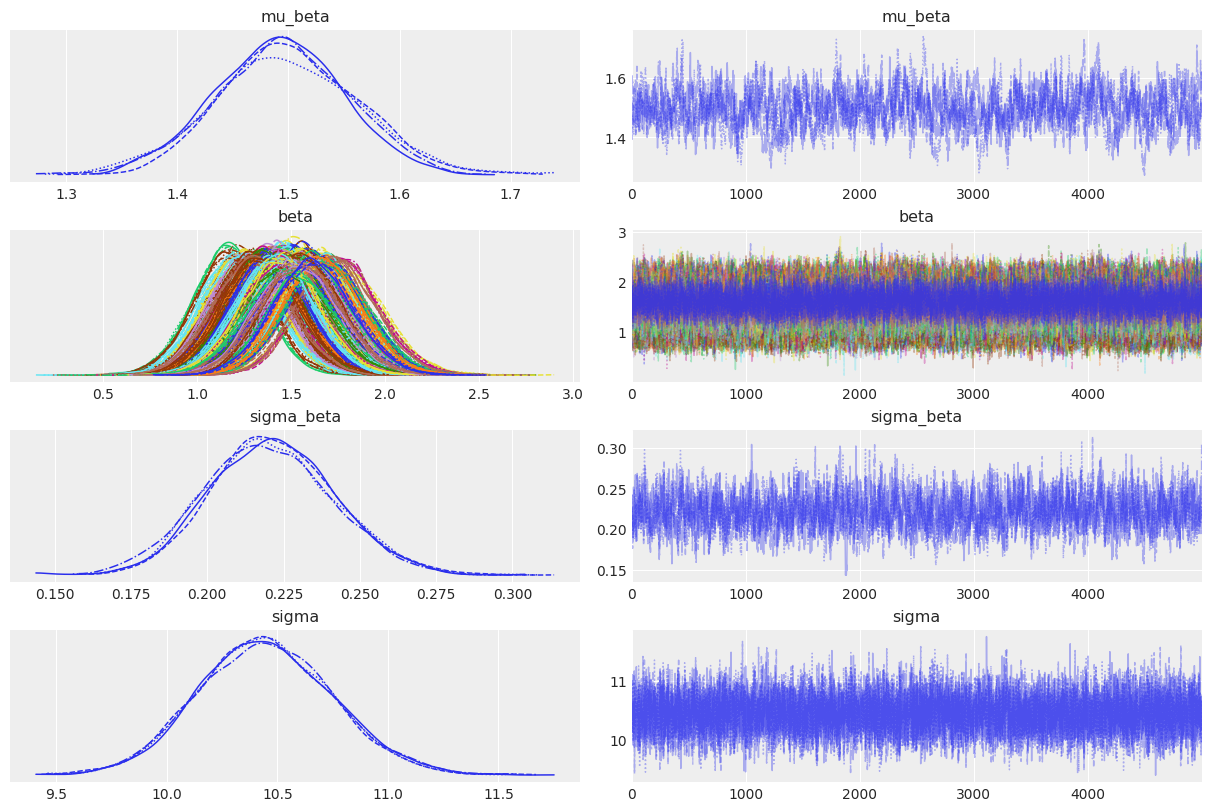

In [ ]:
RANDOM_SEED = 2222
az.style.use("arviz-darkgrid")
coords = {
    "player": player_names,
    "match": match
}
with pm.Model(coords=coords) as hierarchical_ratings_model:
    mu_beta = pm.Normal('mu_beta', mu=0, sigma=1)
    sigma_beta = pm.HalfCauchy('sigma_beta', beta=1)
    beta = pm.Normal('beta', mu=mu_beta, sigma=sigma_beta, shape=651, dims="player") 
    mu = pm.math.dot(x_matrix, beta)
    sigma = pm.HalfCauchy('sigma', beta=5)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=delta_elo, dims="match") 
    prior_checks = pm.sample_prior_predictive(random_seed=RANDOM_SEED, samples=500)
    prior = prior_checks.prior.squeeze(drop=True)
    trace = pm.sample(5000,tune=1000,random_seed=RANDOM_SEED)




In [49]:
# Extract the hyperprior samples and create a long-form DataFrame
df_mu_beta = pd.DataFrame({'value': prior_checks.prior["mu_beta"].values.flatten(), 'hyperparameter': 'mu_beta'})
df_sigma_beta = pd.DataFrame({'value': prior_checks.prior["sigma_beta"].values.flatten(), 'hyperparameter': 'sigma_beta'})

# Combine them into one DataFrame
df_hyper = pd.concat([df_mu_beta, df_sigma_beta])

# Build the lets-plot figure
(
    ggplot(df_hyper, aes(x='value', color='hyperparameter'))
    + geom_density(alpha=0.5, size=2)
    + labs(
        x="Parameter Value",
        y="Density",
        title="Distribution of Hyperpriors"
    )
    + ggsize(800, 600)
)

# Extract and format data for two players
player1_name = player_names[499]
player2_name = player_names[45]
player3_name = player_names[123]
player4_name = player_names[321]   
player5_name = player_names[400]
player6_name = player_names[250]
player7_name = player_names[189]

df_beta1 = pd.DataFrame({'value': prior_checks.prior["beta"].sel(player=player1_name).values.flatten(), 'player': player1_name})
df_beta2 = pd.DataFrame({'value': prior_checks.prior["beta"].sel(player=player2_name).values.flatten(), 'player': player2_name})
df_beta3 = pd.DataFrame({'value': prior_checks.prior["beta"].sel(player=player2_name).values.flatten(), 'player': player3_name})
df_beta4 = pd.DataFrame({'value': prior_checks.prior["beta"].sel(player=player2_name).values.flatten(), 'player': player4_name})
df_beta5 = pd.DataFrame({'value': prior_checks.prior["beta"].sel(player=player2_name).values.flatten(), 'player': player5_name})
df_beta6 = pd.DataFrame({'value': prior_checks.prior["beta"].sel(player=player2_name).values.flatten(), 'player': player6_name})
df_beta7 = pd.DataFrame({'value': prior_checks.prior["beta"].sel(player=player2_name).values.flatten(), 'player': player7_name})
# Combine them into one DataFrame
df_betas = pd.concat([df_beta1, df_beta2, df_beta3, df_beta4, df_beta5, df_beta6, df_beta7])

# Build the plot
(
    ggplot(df_betas, aes(x='value', fill='player'))
    + geom_density(alpha=0.7)
    + labs(
        x="Beta Coefficient Value",
        y="Density",
        title="Prior Distributions for Individual Player Betas"
    )
    + ggsize(800, 600)
)

In [77]:
# Extract the simulated outcomes into a DataFrame
df_prior_pred = pd.DataFrame({
    'simulated_delta_elo': prior_checks.prior_predictive["y_obs"].values.flatten()
})

# Build the histogram
(
    ggplot(df_prior_pred, aes(x='simulated_delta_elo'))
    + geom_histogram(bins=80, color="white", fill="seagreen", alpha=0.7)
    + labs(
        x="Simulated Delta Elo",
        y="Count",
        title="Prior Predictive Distribution of Delta Elo"
    )
    + ggsize(800, 600)
)

In [62]:
(
    ggplot(df_hyper, aes(x='value', color='hyperparameter'))
    + geom_density(alpha=0.3, size=1)
    + labs(
        x="Parameter Value",
        y="Density",
        title="Distribution of Hyperpriors"
    )
    + ggsize(800, 600)
)